In [16]:
# from scipy import stats
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import torch
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.linear_model import LinearRegression
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.neural_network import MLPRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import BayesianRidge
# import warnings
# warnings.filterwarnings('ignore')


# # Set random seed for reproducibility
# np.random.seed(42)
# print("Libraries imported successfully!")

# Fix the imports at the top of your notebook
from scipy import stats as scipy_stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [18]:
class ManualBayesianLinearRegression:
    def __init__(self, n_samples=5000, burn_in=1000):
        self.n_samples = n_samples
        self.burn_in = burn_in
        self.samples = {}
        self.acceptance_rate = {}

    def log_prior(self, beta, alpha, sigma):
        """
        Compute log prior probabilities
        - beta (weights): Normal(0, 10)
        - alpha (intercept): Normal(0, 10) 
        - sigma (noise): Half-Normal(1)
        """
        # Prior on beta coefficients: Normal(0, 10)
        log_p_beta = np.sum(scipy_stats.norm.logpdf(beta, loc=0, scale=10))
        
        # Prior on intercept: Normal(0, 10)
        log_p_alpha = scipy_stats.norm.logpdf(alpha, loc=0, scale=10)
        
        # Prior on sigma: Half-Normal(1) - only positive values
        if sigma <= 0:
            return -np.inf
        log_p_sigma = scipy_stats.halfnorm.logpdf(sigma, scale=1)
        
        return log_p_beta + log_p_alpha + log_p_sigma

    def log_likelihood(self, X, y, beta, alpha, sigma):
        """
        Compute log likelihood: y ~ Normal(X*beta + alpha, sigma)
        """
        if sigma <= 0:
            return -np.inf
            
        mu = X @ beta + alpha  # Linear prediction
        log_lik = np.sum(scipy_stats.norm.logpdf(y, loc=mu, scale=sigma))
        return log_lik

    def log_posterior(self, X, y, beta, alpha, sigma):
        """
        Compute log posterior = log prior + log likelihood
        """
        return self.log_prior(beta, alpha, sigma) + self.log_likelihood(X, y, beta, alpha, sigma)

    def metropolis_hastings_step(self, X, y, current_beta, current_alpha, current_sigma, proposal_std):
        """
        Single Metropolis-Hastings step for all parameters
        """
        # Propose new values
        new_beta = current_beta + np.random.normal(0, proposal_std['beta'], size=len(current_beta))
        new_alpha = current_alpha + np.random.normal(0, proposal_std['alpha'])
        new_sigma = current_sigma + np.random.normal(0, proposal_std['sigma'])
        
        # Compute acceptance probability
        current_log_post = self.log_posterior(X, y, current_beta, current_alpha, current_sigma)
        new_log_post = self.log_posterior(X, y, new_beta, new_alpha, new_sigma)
        
        log_accept_prob = new_log_post - current_log_post
        accept_prob = min(1, np.exp(log_accept_prob))
        
        # Accept or reject
        if np.random.random() < accept_prob:
            return new_beta, new_alpha, new_sigma, True
        else:
            return current_beta, current_alpha, current_sigma, False

    def fit(self, X, y, proposal_std=None):
        """
        Run MCMC sampling
        """
        n_features = X.shape[1]
        
        # Default proposal standard deviations
        if proposal_std is None:
            proposal_std = {
                'beta': 0.1,
                'alpha': 0.1, 
                'sigma': 0.05
            }
        
        # Initialize parameters
        current_beta = np.random.normal(0, 1, size=n_features)
        current_alpha = np.random.normal(0, 1)
        current_sigma = np.abs(np.random.normal(0, 1))
        
        # Storage for samples
        beta_samples = np.zeros((self.n_samples, n_features))
        alpha_samples = np.zeros(self.n_samples)
        sigma_samples = np.zeros(self.n_samples)
        
        # Track acceptance rates
        accepted = {'beta': 0, 'alpha': 0, 'sigma': 0}
        total_proposals = 0
        
        print("Running MCMC sampling...")
        for i in range(self.n_samples + self.burn_in):
            # Metropolis-Hastings step
            current_beta, current_alpha, current_sigma, was_accepted = self.metropolis_hastings_step(
                X, y, current_beta, current_alpha, current_sigma, proposal_std
            )
            
            if was_accepted:
                accepted['beta'] += 1
                accepted['alpha'] += 1  
                accepted['sigma'] += 1
            total_proposals += 1
            
            # Store samples after burn-in
            if i >= self.burn_in:
                sample_idx = i - self.burn_in
                beta_samples[sample_idx] = current_beta
                alpha_samples[sample_idx] = current_alpha
                sigma_samples[sample_idx] = current_sigma
            
            # Progress update
            if (i + 1) % 1000 == 0:
                print(f"Iteration {i + 1}/{self.n_samples + self.burn_in}")
        
        # Store results
        self.samples = {
            'beta': beta_samples,
            'alpha': alpha_samples, 
            'sigma': sigma_samples
        }
        
        # Calculate acceptance rates
        self.acceptance_rate = {param: accepted[param] / total_proposals 
                              for param in accepted.keys()}
        
        print(f"\nSampling completed!")
        print(f"Acceptance rates: {self.acceptance_rate}")

    def summary_statistics(self, feature_names=None):
        """
        Compute summary statistics for posterior samples
        """
        if not self.samples:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        if feature_names is None:
            feature_names = [f'beta_{i}' for i in range(self.samples['beta'].shape[1])]
        
        results = {}
        
        # Beta coefficients
        for i, name in enumerate(feature_names):
            beta_samples = self.samples['beta'][:, i]
            results[name] = {
                'mean': np.mean(beta_samples),
                'std': np.std(beta_samples),
                'median': np.median(beta_samples),
                'ci_2.5': np.percentile(beta_samples, 2.5),
                'ci_97.5': np.percentile(beta_samples, 97.5)
            }
        
        # Alpha (intercept)
        alpha_samples = self.samples['alpha']
        results['alpha'] = {
            'mean': np.mean(alpha_samples),
            'std': np.std(alpha_samples), 
            'median': np.median(alpha_samples),
            'ci_2.5': np.percentile(alpha_samples, 2.5),
            'ci_97.5': np.percentile(alpha_samples, 97.5)
        }
        
        # Sigma (noise)
        sigma_samples = self.samples['sigma']
        results['sigma'] = {
            'mean': np.mean(sigma_samples),
            'std': np.std(sigma_samples),
            'median': np.median(sigma_samples), 
            'ci_2.5': np.percentile(sigma_samples, 2.5),
            'ci_97.5': np.percentile(sigma_samples, 97.5)
        }
        
        return results

    def predict(self, X_new, return_uncertainty=True):
        """
        Make predictions using posterior samples
        """
        if not self.samples:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        n_samples = len(self.samples['alpha'])
        predictions = np.zeros((n_samples, len(X_new)))
        
        for i in range(n_samples):
            mu = X_new @ self.samples['beta'][i] + self.samples['alpha'][i]
            if return_uncertainty:
                # Include noise in predictions
                predictions[i] = np.random.normal(mu, self.samples['sigma'][i])
            else:
                # Just the mean prediction
                predictions[i] = mu
        
        return predictions

    def plot_traces(self, feature_names=None):
        """
        Plot MCMC traces for diagnostics
        """
        if not self.samples:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        if feature_names is None:
            feature_names = [f'beta_{i}' for i in range(self.samples['beta'].shape[1])]
        
        n_params = len(feature_names) + 2  # +2 for alpha and sigma
        n_cols = 3
        n_rows = (n_params + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        plot_idx = 0
        
        # Plot beta traces
        for i, name in enumerate(feature_names):
            axes[plot_idx].plot(self.samples['beta'][:, i])
            axes[plot_idx].set_title(f'Trace: {name}')
            axes[plot_idx].set_xlabel('Iteration')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
        
        # Plot alpha trace
        axes[plot_idx].plot(self.samples['alpha'])
        axes[plot_idx].set_title('Trace: alpha (intercept)')
        axes[plot_idx].set_xlabel('Iteration')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Plot sigma trace
        axes[plot_idx].plot(self.samples['sigma'])
        axes[plot_idx].set_title('Trace: sigma (noise)')
        axes[plot_idx].set_xlabel('Iteration')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

    def plot_posteriors(self, feature_names=None):
        """
        Plot posterior distributions
        """
        if not self.samples:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        if feature_names is None:
            feature_names = [f'beta_{i}' for i in range(self.samples['beta'].shape[1])]
        
        n_params = len(feature_names) + 2
        n_cols = 3
        n_rows = (n_params + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        plot_idx = 0
        
        # Plot beta posteriors
        for i, name in enumerate(feature_names):
            axes[plot_idx].hist(self.samples['beta'][:, i], bins=50, alpha=0.7, density=True)
            axes[plot_idx].set_title(f'Posterior: {name}')
            axes[plot_idx].set_xlabel('Value')
            axes[plot_idx].set_ylabel('Density')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
        
        # Plot alpha posterior
        axes[plot_idx].hist(self.samples['alpha'], bins=50, alpha=0.7, density=True)
        axes[plot_idx].set_title('Posterior: alpha (intercept)')
        axes[plot_idx].set_xlabel('Value')
        axes[plot_idx].set_ylabel('Density')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Plot sigma posterior
        axes[plot_idx].hist(self.samples['sigma'], bins=50, alpha=0.7, density=True)
        axes[plot_idx].set_title('Posterior: sigma (noise)')
        axes[plot_idx].set_xlabel('Value')
        axes[plot_idx].set_ylabel('Density')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

print("Manual Bayesian Linear Regression class created successfully!")

Manual Bayesian Linear Regression class created successfully!


In [3]:
# Check what files are in your simulation_results directory
import os

if os.path.exists('simulation_results'):
    print("Files in simulation_results directory:")
    for file in os.listdir('simulation_results'):
        print(f"  - {file}")
        
    # Look for files with similar names
    target_files = [f for f in os.listdir('simulation_results') 
                   if 'drone_delivery_queue' in f and '20250714_175558' in f]
    print(f"\nFiles matching your pattern: {target_files}")
else:
    print("simulation_results directory not found")
    print("Current directory contents:")
    for item in os.listdir('.'):
        print(f"  - {item}")

Files in simulation_results directory:
  - drone_delivery_queue_20250714_175558.pkl
  - drone_delivery_queue_combined_20250714_175558.csv
  - drone_delivery_queue_params_20250714_175558.json
  - drone_delivery_queue_summary_20250714_175558.json
  - drone_delivery_queue_erlang_s_20250714_175558.csv
  - drone_delivery_queue_erlang_a_20250714_175558.csv

Files matching your pattern: ['drone_delivery_queue_20250714_175558.pkl', 'drone_delivery_queue_combined_20250714_175558.csv', 'drone_delivery_queue_params_20250714_175558.json', 'drone_delivery_queue_summary_20250714_175558.json', 'drone_delivery_queue_erlang_s_20250714_175558.csv', 'drone_delivery_queue_erlang_a_20250714_175558.csv']


In [4]:
# Alternative: Load the combined CSV file directly (easier for ML)
df = pd.read_csv('simulation_results/drone_delivery_queue_combined_20250714_175558.csv')

print("CSV data loaded successfully!")
print("Dataset shape:", df.shape)
print("\nDataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset summary:")
print(df.describe())
print("\nUnique systems:")
print(df['system'].unique())

CSV data loaded successfully!
Dataset shape: (2000000, 15)

Dataset columns:
['customer_id', 'arrival_time', 'queue_length_on_arrival', 'system_size_on_arrival', 'servers_available_on_arrival', 'servers_occupied_on_arrival', 'servers_charging_on_arrival', 'wait_time', 'service_time', 'service_start_time', 'departure_time', 'charging_time', 'abandoned', 'patience_time', 'system']

First few rows:
   customer_id  arrival_time  queue_length_on_arrival  system_size_on_arrival  \
0            0      0.010170                        0                       0   
1            1      0.012818                        0                       1   
2            2      0.024246                        0                       2   
3            3      0.029216                        0                       3   
4            4      0.034432                        0                       4   

   servers_available_on_arrival  servers_occupied_on_arrival  \
0                           100                   

In [5]:
# Split the combined data by system type
df_a = df[df['system'] == 'Erlang-A'].copy()
df_s = df[df['system'] == 'Erlang-S*'].copy()

# Calculate delay probabilities (probability of having to wait)
delay_prob_a = (df_a['wait_time'] > 0).sum() / len(df_a)
delay_prob_s = (df_s['wait_time'] > 0).sum() / len(df_s)

# Calculate abandonment rates
abandoned_a = df_a['abandoned'].mean()
abandoned_s = df_s['abandoned'].mean()

def compute_last_served_wait_time(df):
    df = df.sort_values('arrival_time').reset_index(drop=True).copy()
    
    # Keep only those who actually got served (not abandoned)
    served_df = df[~df['abandoned']].copy()
    served_df = served_df[['service_start_time', 'wait_time']]
    served_df = served_df.sort_values('service_start_time').reset_index(drop=True)

    # For merge_asof, arrival_time must be sorted, and service_start_time must be sorted
    df = df.sort_values('arrival_time').reset_index(drop=True)
    served_df = served_df.rename(columns={'service_start_time': 'arrival_time_of_last_served',
                                          'wait_time': 'wait_time_of_last_served'})
    
    # Find the most recent person to have started service before each arrival
    df = pd.merge_asof(
        df,
        served_df,
        left_on='arrival_time',
        right_on='arrival_time_of_last_served',
        direction='backward'
    )

    # If no one was served before arrival (NaNs), fill with 0
    df['wait_time_of_last_served'] = df['wait_time_of_last_served'].fillna(0.0)
    
    return df

df_a = compute_last_served_wait_time(df_a)
df_s = compute_last_served_wait_time(df_s)

# Display results
print("\n=== DELAY AND ABANDONMENT PROBABILITIES ===")
print(f"Erlang-A:")
print(f"  Delay probability (P(Wait > 0)): {delay_prob_a:.4f}")
print(f"  Abandonment rate: {abandoned_a:.4f}")

print(f"\nErlang-S*:")
print(f"  Delay probability (P(Wait > 0)): {delay_prob_s:.4f}")
print(f"  Abandonment rate: {abandoned_s:.4f}")

print(f"\nComparison:")
print(f"  Delay probability difference (S* - A): {delay_prob_s - delay_prob_a:.4f}")
print(f"  Abandonment rate difference (S* - A): {abandoned_s - abandoned_a:.4f}")



=== DELAY AND ABANDONMENT PROBABILITIES ===
Erlang-A:
  Delay probability (P(Wait > 0)): 0.5117
  Abandonment rate: 0.0395

Erlang-S*:
  Delay probability (P(Wait > 0)): 0.9997
  Abandonment rate: 0.3322

Comparison:
  Delay probability difference (S* - A): 0.4880
  Abandonment rate difference (S* - A): 0.2927


In [32]:
class QueueWaitTimePredictor:
    def __init__(self, feature_set='basic'):
        self.feature_set = feature_set
        self.models = {}
        self.scalers = {}
        self.results = {}
        
        # Define models with clear descriptions
        self.model_configs = {
            'Linear Regression': LinearRegression(),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=100, random_state=42
            ),
            'SVR (RBF)': SVR(kernel='rbf', C=1.0, gamma='scale'),
            'MLP Neural Network': MLPRegressor(
                hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42
            ),
            'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
            'Random Forest': RandomForestRegressor(
                n_estimators=100, random_state=42
            )
        }
    
    def prepare_features(self, df):
        """Prepare feature sets based on configuration"""
        df_work = df.copy()
        
        if self.feature_set == 'basic':
            # Basic features: queue length, occupied servers, available servers, total servers
            features = [
                'queue_length_on_arrival',
                'servers_occupied_on_arrival', 
                'servers_available_on_arrival',
                'servers_charging_on_arrival'
            ]
            
            # Calculate total servers
            # df_work['total_servers'] = (df_work['servers_occupied_on_arrival'] + 
            #                           df_work['servers_available_on_arrival'] + 
            #                           df_work['servers_charging_on_arrival'])
            # features.append('total_servers')
                
        elif self.feature_set == 'extended':
            # Extended features: basic + additional queue dynamics
            features = [
                'queue_length_on_arrival',
                'servers_occupied_on_arrival',
                'servers_available_on_arrival',
                'system_size_on_arrival',  # Total customers in system
                'servers_charging_on_arrival'  # Charging servers
            ]
            
            # Calculate total servers
            # df_work['total_servers'] = (df_work['servers_occupied_on_arrival'] + 
            #                           df_work['servers_available_on_arrival'] + 
            #                           df_work['servers_charging_on_arrival'])
            # features.append('total_servers')
                
            # Create "previous customer wait time" feature
            # Sort by arrival time and create lag feature
            df_work = df_work.sort_values('arrival_time').reset_index(drop=True)
            df_work['previous_wait_time'] = df_work['wait_time'].shift(1).fillna(0)
            features.append('previous_wait_time')
                
        else:
            raise ValueError("feature_set must be 'basic' or 'extended'")
        
        # Check which features actually exist
        available_features = [f for f in features if f in df_work.columns]
        missing_features = [f for f in features if f not in df_work.columns]
        
        if missing_features:
            print(f"Warning: Missing features {missing_features}")
            
        print(f"Using features: {available_features}")
        
        X = df_work[available_features]
        y = df_work['wait_time']
        
        return X, y
    
    def train_models(self, df, test_size=0.2, sample_size=None):
        """Train all models and evaluate performance"""
        
        # Sample data if specified (useful for large datasets)
        if sample_size and len(df) > sample_size:
            df_sample = df.sample(n=sample_size, random_state=42)
            print(f"Sampling {sample_size:,} rows from {len(df):,} total rows")
        else:
            df_sample = df
            
        X, y = self.prepare_features(df_sample)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        # Store test data for later use
        self.X_test = X_test
        self.y_test = y_test
        
        print(f"\n{'='*50}")
        print(f"TRAINING MODELS WITH {self.feature_set.upper()} FEATURES")
        print(f"{'='*50}")
        print(f"Feature columns: {list(X.columns)}")
        print(f"Training set size: {X_train.shape[0]:,}, Test set size: {X_test.shape[0]:,}")
        print(f"Target variable range: {y.min():.4f} to {y.max():.4f}")
        
        for name, model in self.model_configs.items():
            print(f"\nTraining {name}...")
            
            try:
                # Scale features for models that benefit from scaling
                if name in ['SVR (RBF)', 'MLP Neural Network', 'K-Nearest Neighbors']:
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    self.scalers[name] = scaler
                    
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                
                # Store model
                self.models[name] = model
                
                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                self.results[name] = {
                    'MSE': mse,
                    'MAE': mae,
                    'R2': r2,
                    'RMSE': np.sqrt(mse),
                    'predictions': y_pred
                }
                
                print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
                
            except Exception as e:
                print(f"  Error training {name}: {str(e)}")
                continue
    
    def get_results_summary(self):
        """Return summary of model performance"""
        if not self.results:
            print("No results available. Please train models first.")
            return None
            
        summary = pd.DataFrame({
            'Model': list(self.results.keys()),
            'MSE': [self.results[model]['MSE'] for model in self.results.keys()],
            'MAE': [self.results[model]['MAE'] for model in self.results.keys()],
            'RMSE': [self.results[model]['RMSE'] for model in self.results.keys()],
            'R²': [self.results[model]['R2'] for model in self.results.keys()]
        })
        
        return summary.sort_values('R²', ascending=False)
    
    def plot_results(self):
        """Plot model performance comparison"""
        summary = self.get_results_summary()
        if summary is None:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # R² comparison
        colors = plt.cm.Set3(np.linspace(0, 1, len(summary)))
        bars = axes[0,0].barh(summary['Model'], summary['R²'], color=colors)
        axes[0,0].set_xlabel('R² Score')
        axes[0,0].set_title(f'Model Comparison - R² Score ({self.feature_set} features)')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, r2) in enumerate(zip(bars, summary['R²'])):
            axes[0,0].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                          f'{r2:.3f}', va='center', fontsize=9)
        
        # MAE comparison
        bars = axes[0,1].barh(summary['Model'], summary['MAE'], color=colors)
        axes[0,1].set_xlabel('Mean Absolute Error')
        axes[0,1].set_title(f'Model Comparison - MAE ({self.feature_set} features)')
        axes[0,1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, mae) in enumerate(zip(bars, summary['MAE'])):
            axes[0,1].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                          f'{mae:.3f}', va='center', fontsize=9)
        
        # Prediction vs Actual for best model
        best_model = summary.iloc[0]['Model']
        y_pred_best = self.results[best_model]['predictions']
        
        scatter = axes[1,0].scatter(self.y_test, y_pred_best, alpha=0.6, s=20)
        axes[1,0].plot([self.y_test.min(), self.y_test.max()], 
                       [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[1,0].set_xlabel('Actual Wait Time')
        axes[1,0].set_ylabel('Predicted Wait Time')
        axes[1,0].set_title(f'Best Model: {best_model}\nR² = {summary.iloc[0]["R²"]:.4f}')
        axes[1,0].grid(True, alpha=0.3)
        
        # Residuals for best model
        residuals = self.y_test - y_pred_best
        axes[1,1].scatter(y_pred_best, residuals, alpha=0.6, s=20)
        axes[1,1].axhline(y=0, color='r', linestyle='--')
        axes[1,1].set_xlabel('Predicted Wait Time')
        axes[1,1].set_ylabel('Residuals')
        axes[1,1].set_title(f'Residuals - {best_model}')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return summary

    def extract_equations(self):
        """
        Extract and display mathematical equations for interpretable models
        """
        if not self.models:
            print("No trained models found. Please train models first.")
            return None
        
        print("\n" + "="*80)
        print(f"MATHEMATICAL EQUATIONS FOR PREDICTIVE MODELS ({self.feature_set.upper()} FEATURES)")
        print("="*80)
        
        # Get feature names
        if hasattr(self, 'X_test'):
            feature_names = list(self.X_test.columns)
        else:
            print("Feature names not available. Train models first.")
            return None
        
        # Short names for display
        feature_short_names = {
            'queue_length_on_arrival': 'Q',
            'servers_occupied_on_arrival': 'S_occ', 
            'servers_available_on_arrival': 'S_avail',
            'servers_charging_on_arrival': 'S_char',
            'system_size_on_arrival': 'N_sys',
            'previous_wait_time': 'W_prev'
        }
        
        short_names = [feature_short_names.get(f, f) for f in feature_names]
        
        print(f"\nFeature Legend:")
        for full_name, short_name in zip(feature_names, short_names):
            print(f"  {short_name}: {full_name}")
        print()
        
        equations = {}
        
        # 1. LINEAR REGRESSION
        if 'Linear Regression' in self.models:
            model = self.models['Linear Regression']
            print("1. LINEAR REGRESSION")
            print("-" * 40)
            
            equation = f"Wait_Time = {model.intercept_:.4f}"
            for i, (coef, name) in enumerate(zip(model.coef_, short_names)):
                sign = "+" if coef >= 0 else ""
                equation += f" {sign}{coef:.4f}·{name}"
            
            print(f"Equation: {equation}")
            print(f"R² = {self.results['Linear Regression']['R2']:.4f}")
            
            # Store equation
            equations['Linear Regression'] = {
                'equation': equation,
                'intercept': model.intercept_,
                'coefficients': dict(zip(feature_names, model.coef_)),
                'r2': self.results['Linear Regression']['R2']
            }
            
            # Coefficient interpretation
            print("\nCoefficient Interpretation:")
            print(f"  Intercept: {model.intercept_:.4f} (baseline wait time)")
            for coef, full_name, short_name in zip(model.coef_, feature_names, short_names):
                effect = "increases" if coef > 0 else "decreases"
                print(f"  {short_name}: {coef:.4f} (each unit {effect} wait time by {abs(coef):.4f})")
            print()
        
        # 2. RANDOM FOREST - Feature Importance
        if 'Random Forest' in self.models:
            model = self.models['Random Forest']
            print("2. RANDOM FOREST - FEATURE IMPORTANCE")
            print("-" * 40)
            print("Note: Random Forest doesn't have a simple equation, but here are feature importances:")
            
            importances = model.feature_importances_
            sorted_idx = np.argsort(importances)[::-1]
            
            importance_dict = {}
            for i in sorted_idx:
                importance_dict[feature_names[i]] = importances[i]
                print(f"  {short_names[i]}: {importances[i]:.4f} ({importances[i]/sum(importances)*100:.1f}%)")
            
            equations['Random Forest'] = {
                'feature_importances': importance_dict,
                'r2': self.results['Random Forest']['R2']
            }
            
            print(f"R² = {self.results['Random Forest']['R2']:.4f}")
            print()
        
        # 3. NON-PARAMETRIC MODELS INFO
        non_parametric = ['K-Nearest Neighbors', 'SVR (RBF)', 'MLP Neural Network', 'Gradient Boosting']
        available_non_param = [model for model in non_parametric if model in self.models]
        
        if available_non_param:
            print("3. NON-PARAMETRIC MODELS (No Closed-Form Equations)")
            print("-" * 40)
            print("The following models don't have simple mathematical equations:")
            
            for model_name in available_non_param:
                r2 = self.results[model_name]['R2']
                mae = self.results[model_name]['MAE']
                
                model_info = {'r2': r2, 'mae': mae}
                
                if model_name == 'K-Nearest Neighbors':
                    k = self.models[model_name].n_neighbors
                    model_info['n_neighbors'] = k
                    print(f"  • {model_name}: Uses {k} nearest neighbors (R² = {r2:.4f})")
                    
                elif model_name == 'SVR (RBF)':
                    C = self.models[model_name].C
                    gamma = self.models[model_name].gamma
                    model_info['C'] = C
                    model_info['gamma'] = gamma
                    print(f"  • {model_name}: RBF kernel with C={C}, γ={gamma} (R² = {r2:.4f})")
                    
                elif model_name == 'MLP Neural Network':
                    layers = self.models[model_name].hidden_layer_sizes
                    model_info['layers'] = layers
                    print(f"  • {model_name}: Neural network with layers {layers} (R² = {r2:.4f})")
                    
                elif model_name == 'Gradient Boosting':
                    n_est = self.models[model_name].n_estimators
                    model_info['n_estimators'] = n_est
                    print(f"  • {model_name}: Ensemble of {n_est} trees (R² = {r2:.4f})")
                
                equations[model_name] = model_info
            print()
        
        # 4. MODEL PERFORMANCE SUMMARY
        print("4. MODEL PERFORMANCE SUMMARY")
        print("-" * 40)
        results_summary = self.get_results_summary()
        print("Ranked by R² Score:")
        for i, row in results_summary.iterrows():
            # Use the correct column name with superscript
            print(f"  {i+1:2d}. {row['Model']:20s} R² = {row['R²']:.4f}, MAE = {row['MAE']:.4f}")
        
        return equations

    def generate_latex_equations(self):
        """
        Generate LaTeX formatted equations for academic papers
        """
        if 'Linear Regression' not in self.models:
            print("Linear Regression model not found.")
            return None
        
        model = self.models['Linear Regression']
        feature_names = list(self.X_test.columns)
        
        print("\n" + "="*60)
        print("LATEX EQUATIONS FOR ACADEMIC PAPERS")
        print("="*60)
        
        # LaTeX equation
        latex_eq = r"\hat{W} = " + f"{model.intercept_:.4f}"
        
        latex_vars = {
            'queue_length_on_arrival': 'Q',
            'servers_occupied_on_arrival': 'S_{\\text{occ}}', 
            'servers_available_on_arrival': 'S_{\\text{avail}}',
            'servers_charging_on_arrival': 'S_{\\text{char}}',
            'system_size_on_arrival': 'N_{\\text{sys}}',
            'previous_wait_time': 'W_{\\text{prev}}'
        }
        
        for coef, name in zip(model.coef_, feature_names):
            var_name = latex_vars.get(name, name)
            sign = " + " if coef >= 0 else " - "
            latex_eq += f"{sign}{abs(coef):.4f} \\cdot {var_name}"
        
        print(f"Linear Regression LaTeX ({self.feature_set} features):")
        print(f"\\begin{{equation}}")
        print(f"{latex_eq}")
        print(f"\\end{{equation}}")
        print(f"where $R^2 = {self.results['Linear Regression']['R2']:.4f}$")
        
        return latex_eq
        
    def compare_linear_equations(self, other_predictor):
        """
        Compare linear regression equations between two predictors
        """
        print("\n" + "="*80)
        print("SIDE-BY-SIDE COMPARISON OF LINEAR REGRESSION EQUATIONS")
        print("="*80)
        
        if 'Linear Regression' not in self.models or 'Linear Regression' not in other_predictor.models:
            print("Both predictors must have trained Linear Regression models.")
            return
        
        # Self model
        self_model = self.models['Linear Regression']
        self_features = list(self.X_test.columns)
        self_r2 = self.results['Linear Regression']['R2']
        
        # Other model  
        other_model = other_predictor.models['Linear Regression']
        other_features = list(other_predictor.X_test.columns)
        other_r2 = other_predictor.results['Linear Regression']['R2']
        
        print(f"{self.feature_set.upper()} FEATURES MODEL:")
        print("-" * 40)
        self_eq = f"Wait_Time = {self_model.intercept_:.4f}"
        for coef, name in zip(self_model.coef_, self_features):
            sign = "+" if coef >= 0 else ""
            self_eq += f" {sign}{coef:.4f}·{name}"
        print(f"{self_eq}")
        print(f"R² = {self_r2:.4f}")
        
        print(f"\n{other_predictor.feature_set.upper()} FEATURES MODEL:")
        print("-" * 40)
        other_eq = f"Wait_Time = {other_model.intercept_:.4f}"
        for coef, name in zip(other_model.coef_, other_features):
            sign = "+" if coef >= 0 else ""
            other_eq += f" {sign}{coef:.4f}·{name}"
        print(f"{other_eq}")
        print(f"R² = {other_r2:.4f}")
        
        print(f"\nIMPROVEMENT:")
        print(f"R² improvement: {other_r2 - self_r2:.4f} ({(other_r2 - self_r2)/self_r2*100:.1f}%)")
        
        # Coefficient comparison for common features
        print("\nCOEFFICIENT COMPARISON (Common Features):")
        print("-" * 50)
        for i, feature in enumerate(self_features):
            if feature in other_features:
                self_coef = self_model.coef_[i]
                other_idx = other_features.index(feature)
                other_coef = other_model.coef_[other_idx]
                change = other_coef - self_coef
                print(f"{feature:30s}: {self_coef:8.4f} → {other_coef:8.4f} (Δ = {change:+7.4f})")
        
        # New features in other model
        new_features = [f for f in other_features if f not in self_features]
        if new_features:
            print(f"\nNEW FEATURES IN {other_predictor.feature_set.upper()} MODEL:")
            print("-" * 40)
            for feature in new_features:
                idx = other_features.index(feature)
                coef = other_model.coef_[idx]
                print(f"{feature:30s}: {coef:8.4f}")
        
        return {
            'self_equation': self_eq,
            'other_equation': other_eq,
            'self_r2': self_r2,
            'other_r2': other_r2,
            'improvement': other_r2 - self_r2
        }

print("QueueWaitTimePredictor class defined successfully!")

QueueWaitTimePredictor class defined successfully!


Preparing data for manual Bayesian regression...
Training data shape: (4000, 4)
Training target range: [0.000, 0.844]
Fitting Manual Bayesian Linear Regression...
Running MCMC sampling...
Iteration 1000/4000
Iteration 2000/4000
Iteration 3000/4000
Iteration 4000/4000

Sampling completed!
Acceptance rates: {'beta': 0.013, 'alpha': 0.013, 'sigma': 0.013}

POSTERIOR SUMMARY STATISTICS

queue_length_on_arrival:
  Mean: 0.0784
  Std:  0.0000
  95% CI: [0.0784, 0.0784]

servers_occupied_on_arrival:
  Mean: 0.3573
  Std:  0.0000
  95% CI: [0.3573, 0.3573]

servers_available_on_arrival:
  Mean: 0.0368
  Std:  0.0000
  95% CI: [0.0368, 0.0368]

servers_charging_on_arrival:
  Mean: 0.3158
  Std:  0.0000
  95% CI: [0.3158, 0.3158]

alpha:
  Mean: 0.3317
  Std:  0.0000
  95% CI: [0.3317, 0.3317]

sigma:
  Mean: 0.1444
  Std:  0.0000
  95% CI: [0.1444, 0.1444]

Acceptance rates: {'beta': 0.013, 'alpha': 0.013, 'sigma': 0.013}

Generating diagnostic plots...


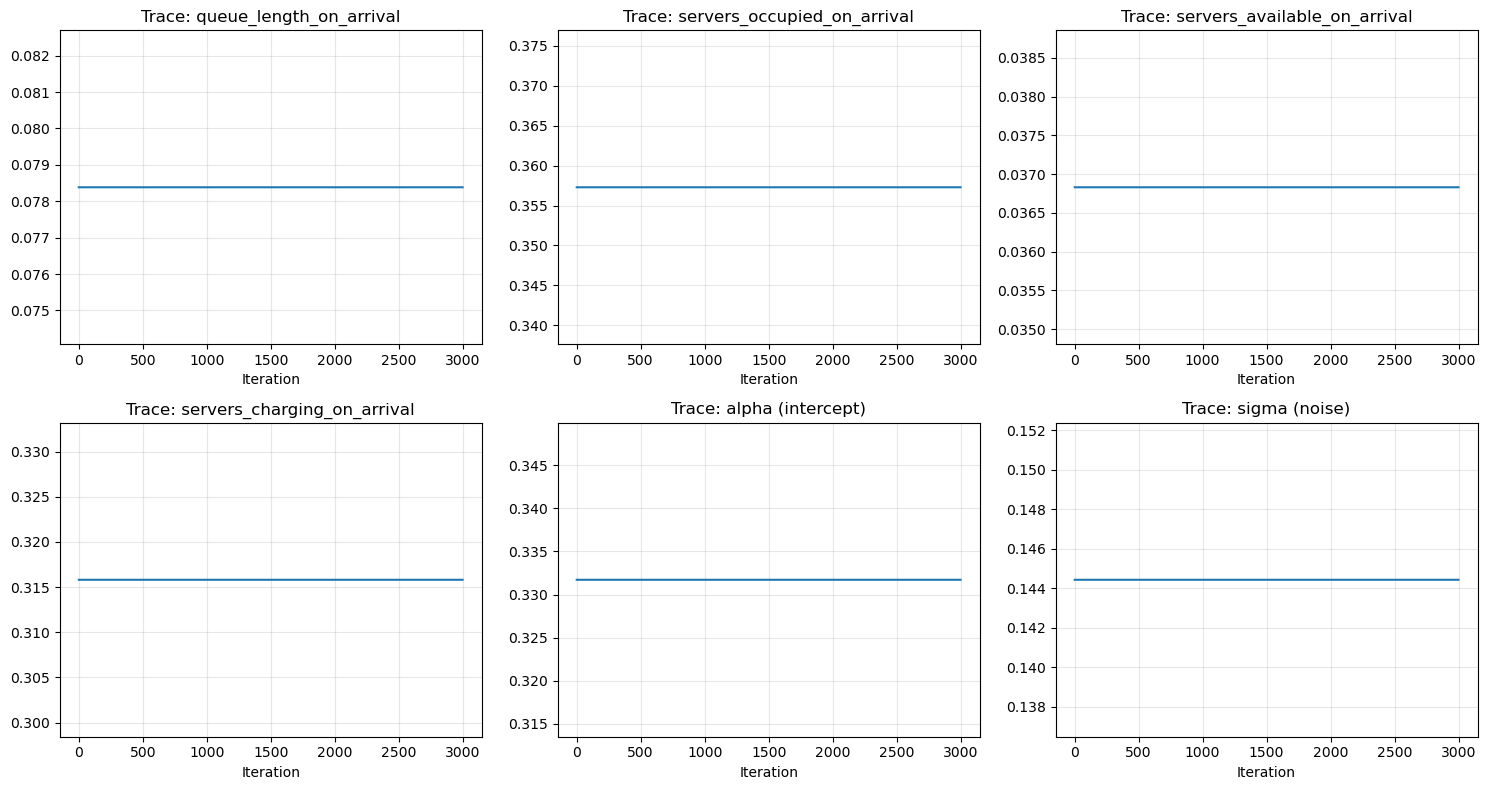

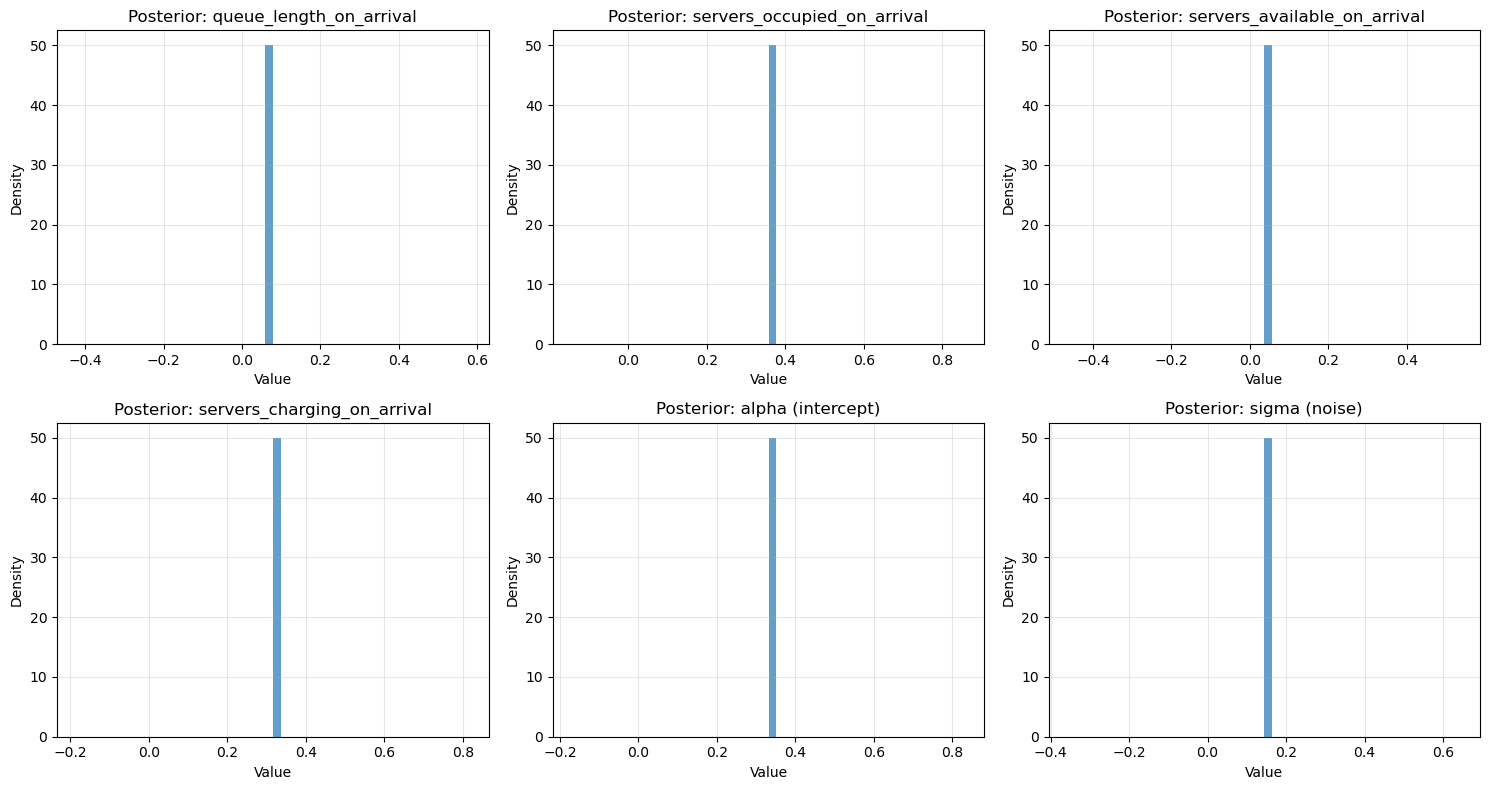

In [19]:
# Prepare data for manual Bayesian regression
features = [
    'queue_length_on_arrival',
    'servers_occupied_on_arrival', 
    'servers_available_on_arrival',
    'servers_charging_on_arrival'
]

target = 'wait_time'

# Sample data for faster computation
print("Preparing data for manual Bayesian regression...")
df_sample = df_s.sample(n=5000, random_state=42)  # Smaller sample for MCMC
X = df_sample[features].values
y = df_sample[target].values

# Standardize features (important for MCMC stability)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training target range: [{y_train.min():.3f}, {y_train.max():.3f}]")

# Fit the manual Bayesian model
print("Fitting Manual Bayesian Linear Regression...")
manual_bayes = ManualBayesianLinearRegression(n_samples=3000, burn_in=1000)
manual_bayes.fit(X_train, y_train)

# Get summary statistics
summary_stats = manual_bayes.summary_statistics(feature_names=features)

print("\n" + "="*60)
print("POSTERIOR SUMMARY STATISTICS")
print("="*60)

for param, stats in summary_stats.items():
    print(f"\n{param}:")
    print(f"  Mean: {stats['mean']:.4f}")
    print(f"  Std:  {stats['std']:.4f}")
    print(f"  95% CI: [{stats['ci_2.5']:.4f}, {stats['ci_97.5']:.4f}]")

print(f"\nAcceptance rates: {manual_bayes.acceptance_rate}")

# Plot diagnostics
print("\nGenerating diagnostic plots...")
manual_bayes.plot_traces(feature_names=features)
manual_bayes.plot_posteriors(feature_names=features)

Making Bayesian predictions...

Manual Bayesian Regression Performance:
  MSE: 0.0212
  MAE: 0.1134
  R²:  0.1295

Classical Linear Regression Performance:
  MSE: 0.0198
  MAE: 0.1091
  R²:  0.1878


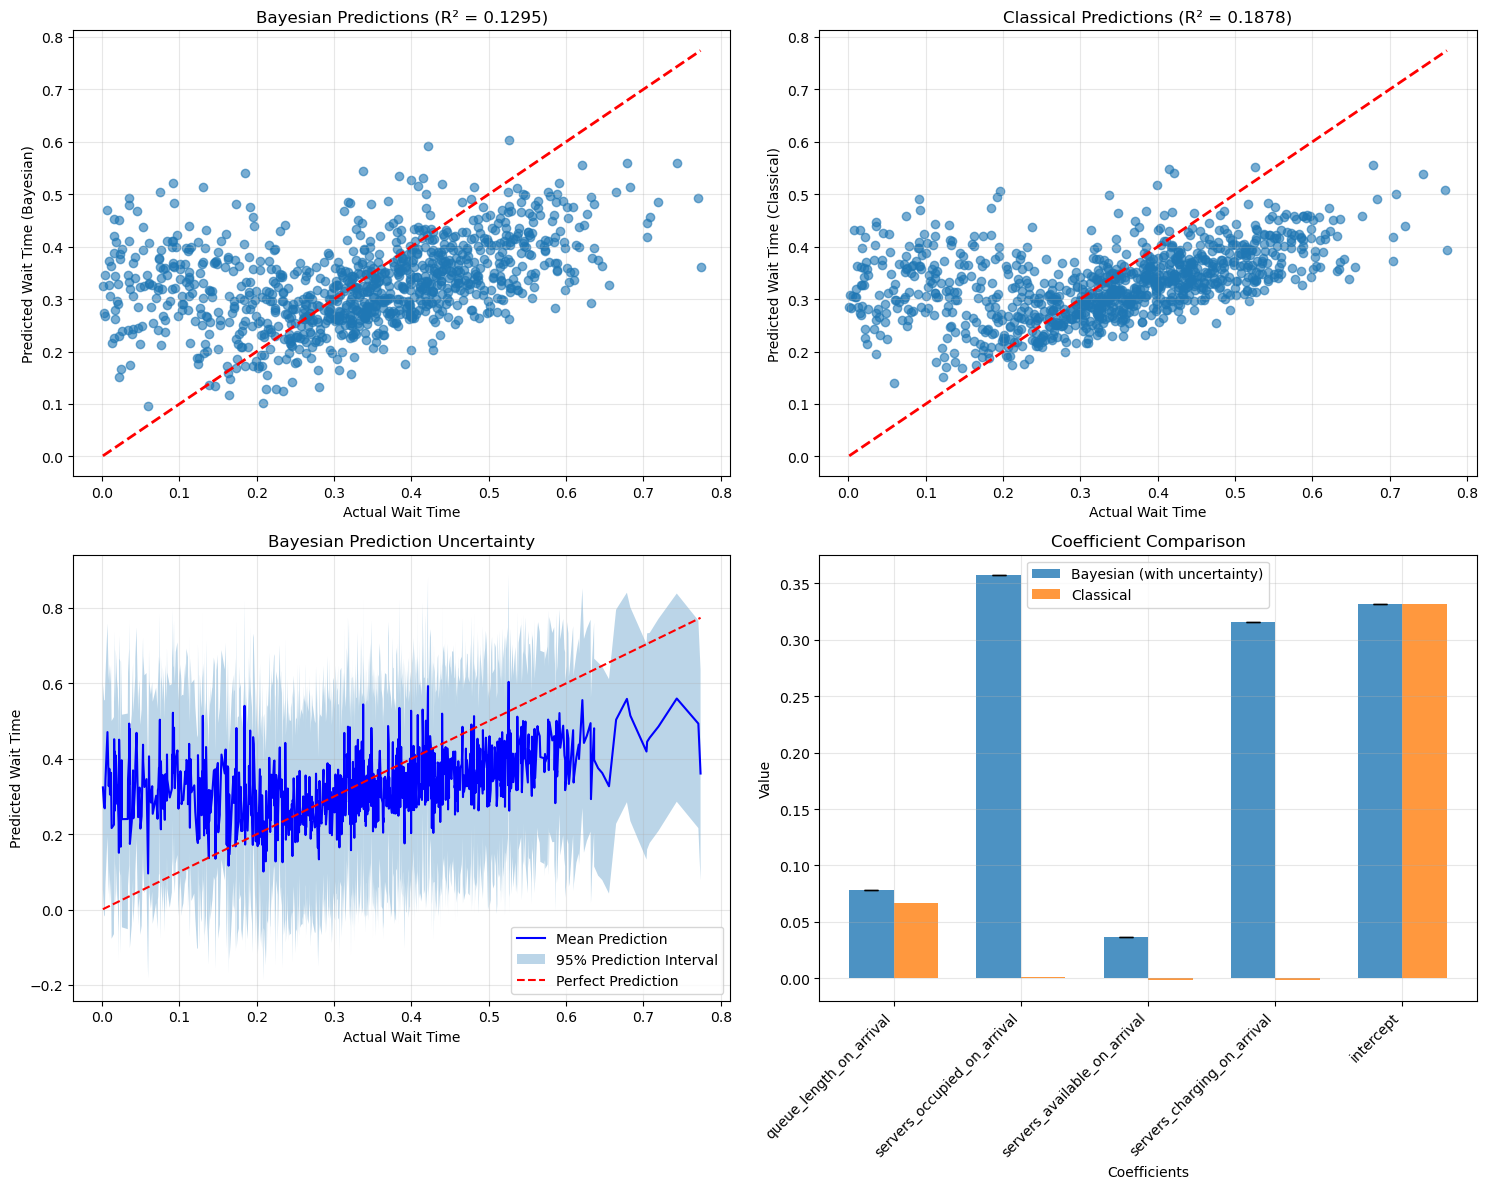


Bayesian regression provides uncertainty quantification!
Average prediction interval width: 0.5652


In [21]:
# Make predictions and compare with classical methods
print("Making Bayesian predictions...")
predictions = manual_bayes.predict(X_test, return_uncertainty=True)

# Calculate prediction statistics
pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
pred_ci_lower = np.percentile(predictions, 2.5, axis=0)
pred_ci_upper = np.percentile(predictions, 97.5, axis=0)

# Calculate metrics
mse_bayes = np.mean((pred_mean - y_test)**2)
mae_bayes = np.mean(np.abs(pred_mean - y_test))
r2_bayes = 1 - (np.sum((y_test - pred_mean)**2) / np.sum((y_test - np.mean(y_test))**2))

print(f"\nManual Bayesian Regression Performance:")
print(f"  MSE: {mse_bayes:.4f}")
print(f"  MAE: {mae_bayes:.4f}")
print(f"  R²:  {r2_bayes:.4f}")

# Compare with classical linear regression
classical_lr = LinearRegression()
classical_lr.fit(X_train, y_train)
pred_classical = classical_lr.predict(X_test)

mse_classical = np.mean((pred_classical - y_test)**2)
mae_classical = np.mean(np.abs(pred_classical - y_test))
r2_classical = classical_lr.score(X_test, y_test)

print(f"\nClassical Linear Regression Performance:")
print(f"  MSE: {mse_classical:.4f}")
print(f"  MAE: {mae_classical:.4f}")
print(f"  R²:  {r2_classical:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prediction vs Actual (Bayesian)
axes[0,0].scatter(y_test, pred_mean, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Wait Time')
axes[0,0].set_ylabel('Predicted Wait Time (Bayesian)')
axes[0,0].set_title(f'Bayesian Predictions (R² = {r2_bayes:.4f})')
axes[0,0].grid(True, alpha=0.3)

# Prediction vs Actual (Classical)
axes[0,1].scatter(y_test, pred_classical, alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Wait Time')
axes[0,1].set_ylabel('Predicted Wait Time (Classical)')
axes[0,1].set_title(f'Classical Predictions (R² = {r2_classical:.4f})')
axes[0,1].grid(True, alpha=0.3)

# Prediction intervals (Bayesian uncertainty)
sort_idx = np.argsort(y_test)
axes[1,0].plot(y_test[sort_idx], pred_mean[sort_idx], 'b-', label='Mean Prediction')
axes[1,0].fill_between(y_test[sort_idx], pred_ci_lower[sort_idx], pred_ci_upper[sort_idx], 
                       alpha=0.3, label='95% Prediction Interval')
axes[1,0].plot(y_test[sort_idx], y_test[sort_idx], 'r--', label='Perfect Prediction')
axes[1,0].set_xlabel('Actual Wait Time')
axes[1,0].set_ylabel('Predicted Wait Time')
axes[1,0].set_title('Bayesian Prediction Uncertainty')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Coefficient comparison
coef_names = features + ['intercept']
bayesian_coefs = [summary_stats[name]['mean'] for name in features] + [summary_stats['alpha']['mean']]
classical_coefs = classical_lr.coef_.tolist() + [classical_lr.intercept_]
bayesian_errors = [summary_stats[name]['std'] for name in features] + [summary_stats['alpha']['std']]

x_pos = np.arange(len(coef_names))
width = 0.35

bars1 = axes[1,1].bar(x_pos - width/2, bayesian_coefs, width, yerr=bayesian_errors, 
                      label='Bayesian (with uncertainty)', alpha=0.8, capsize=5)
bars2 = axes[1,1].bar(x_pos + width/2, classical_coefs, width, 
                      label='Classical', alpha=0.8)
axes[1,1].set_xlabel('Coefficients')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Coefficient Comparison')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(coef_names, rotation=45, ha='right')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBayesian regression provides uncertainty quantification!")
print(f"Average prediction interval width: {np.mean(pred_ci_upper - pred_ci_lower):.4f}")

TRAINING MODELS ON ERLANG-S* SYSTEM

BASIC FEATURE SET:
- Queue length on arrival
- Number of servers occupied
- Number of servers available
- Total number of servers
Sampling 100,000 rows from 1,000,000 total rows
Using features: ['queue_length_on_arrival', 'servers_occupied_on_arrival', 'servers_available_on_arrival', 'servers_charging_on_arrival']

TRAINING MODELS WITH BASIC FEATURES
Feature columns: ['queue_length_on_arrival', 'servers_occupied_on_arrival', 'servers_available_on_arrival', 'servers_charging_on_arrival']
Training set size: 80,000, Test set size: 20,000
Target variable range: 0.0000 to 0.9112

Training Linear Regression...
  MSE: 0.0199, MAE: 0.1092, R²: 0.1745

Training Gradient Boosting...
  MSE: 0.0198, MAE: 0.1086, R²: 0.1769

Training SVR (RBF)...
  MSE: 0.0200, MAE: 0.1073, R²: 0.1688

Training MLP Neural Network...
  MSE: 0.0200, MAE: 0.1071, R²: 0.1702

Training K-Nearest Neighbors...
  MSE: 0.0236, MAE: 0.1186, R²: 0.0189

Training Random Forest...
  MSE: 0.0

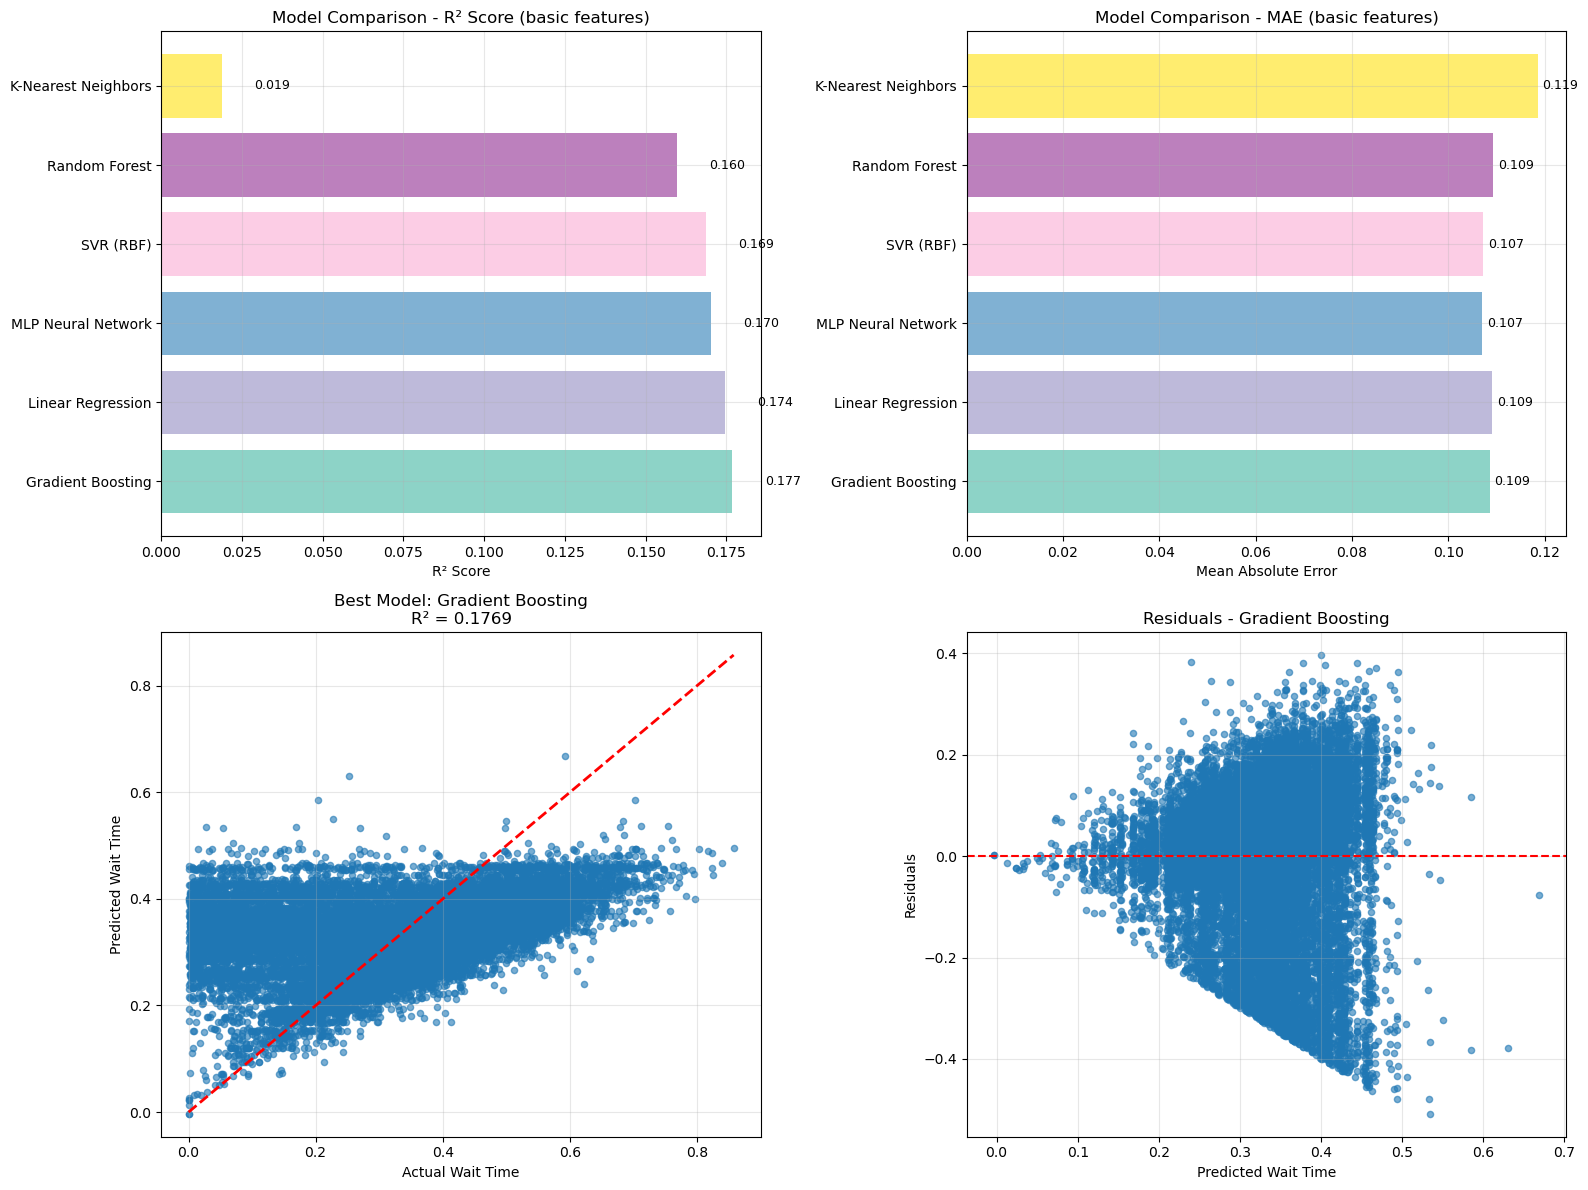

,Model,MSE,MAE,RMSE,R²
1,Gradient Boosting,0.019818,0.108571,0.140778,0.176853
0,Linear Regression,0.019875,0.109155,0.140980,0.174493
3,MLP Neural Network,0.019978,0.107064,0.141345,0.170209
2,SVR (RBF),0.020013,0.107290,0.141467,0.168775
5,Random Forest,0.020234,0.109378,0.142245,0.159605
4,K-Nearest Neighbors,0.023622,0.118593,0.153694,0.018876


In [38]:
# Train models on Erlang-S* system with BASIC features
print("="*60)
print("TRAINING MODELS ON ERLANG-S* SYSTEM")
print("="*60)

print("\nBASIC FEATURE SET:")
print("- Queue length on arrival")
print("- Number of servers occupied") 
print("- Number of servers available")
print("- Total number of servers")

# Use a sample for faster training (you can increase this or remove sampling)
predictor_basic = QueueWaitTimePredictor(feature_set='basic')
predictor_basic.train_models(df_s, sample_size=100000)  # Sample 100k for speed

# Get results summary
results_basic = predictor_basic.get_results_summary()
print("\n=== BASIC FEATURES MODEL RESULTS (ERLANG-S*) ===")
print(results_basic)

# Extract equations for basic feature set models
print("EXTRACTING EQUATIONS FOR BASIC FEATURE SET MODELS")
if 'predictor_basic' in locals():
    basic_equations = predictor_basic.extract_equations()
    #latex_eq_basic = predictor_basic.generate_latex_equations()
else:
    print("Basic predictor not found. Please train basic models first.")

# Plot results
predictor_basic.plot_results()


EXTENDED FEATURE SET:
- All basic features PLUS:
- System size on arrival (total customers in system)
- Servers in charging state
- Previous customer's wait time
Sampling 100,000 rows from 1,000,000 total rows
Using features: ['queue_length_on_arrival', 'servers_occupied_on_arrival', 'servers_available_on_arrival', 'system_size_on_arrival', 'servers_charging_on_arrival', 'previous_wait_time']

TRAINING MODELS WITH EXTENDED FEATURES
Feature columns: ['queue_length_on_arrival', 'servers_occupied_on_arrival', 'servers_available_on_arrival', 'system_size_on_arrival', 'servers_charging_on_arrival', 'previous_wait_time']
Training set size: 80,000, Test set size: 20,000
Target variable range: 0.0000 to 0.9112

Training Linear Regression...
  MSE: 0.0196, MAE: 0.1086, R²: 0.1957

Training Gradient Boosting...
  MSE: 0.0192, MAE: 0.1072, R²: 0.2124

Training SVR (RBF)...
  MSE: 0.0194, MAE: 0.1071, R²: 0.2036

Training MLP Neural Network...
  MSE: 0.0193, MAE: 0.1057, R²: 0.2100

Training K-Ne

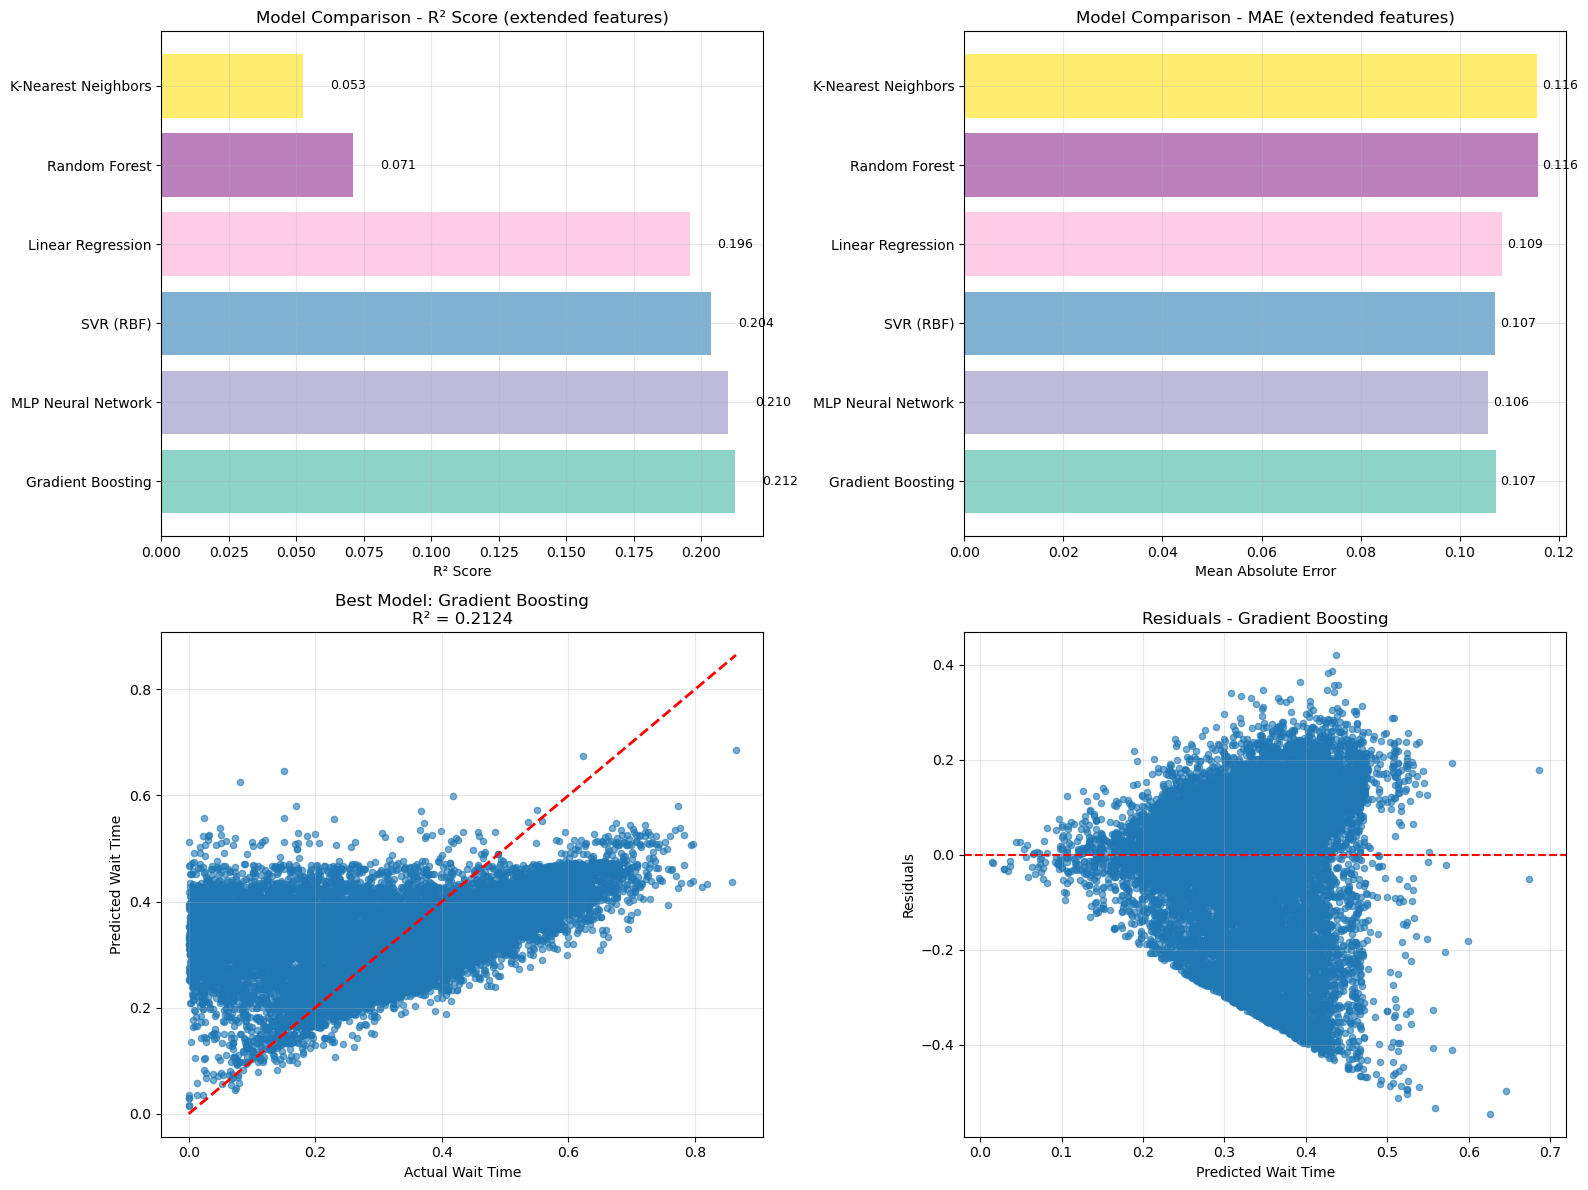

,Model,MSE,MAE,RMSE,R²
1,Gradient Boosting,0.019231,0.107212,0.138677,0.212395
3,MLP Neural Network,0.019289,0.105718,0.138884,0.210040
2,SVR (RBF),0.019447,0.107084,0.139452,0.203568
0,Linear Regression,0.019639,0.108573,0.140138,0.195712
5,Random Forest,0.022683,0.115670,0.150608,0.071040
4,K-Nearest Neighbors,0.023133,0.115656,0.152094,0.052611


In [39]:
# Train models on Erlang-S* system with EXTENDED features
print("\nEXTENDED FEATURE SET:")
print("- All basic features PLUS:")
print("- System size on arrival (total customers in system)")
print("- Servers in charging state")
print("- Previous customer's wait time")

predictor_extended = QueueWaitTimePredictor(feature_set='extended')
predictor_extended.train_models(df_s, sample_size=100000)  # Sample 100k for speed

# Get results summary
results_extended = predictor_extended.get_results_summary()
print("\n=== EXTENDED FEATURES MODEL RESULTS (ERLANG-S*) ===")
print(results_extended)

# Extract equations for extended feature set models  
print("\n\nEXTRACTING EQUATIONS FOR EXTENDED FEATURE SET MODELS")
if 'predictor_extended' in locals():
    extended_equations = predictor_extended.extract_equations()
    #latex_eq_extended = predictor_extended.generate_latex_equations()
else:
    print("Extended predictor not found. Please train extended models first.")

# Plot results
predictor_extended.plot_results()

In [35]:
def predict_wait_time(predictor, queue_length, servers_occupied, servers_available, servers_charging, 
                     system_size=None, previous_wait_time=None):
    """
    Predict wait time given queue state variables
    
    Parameters:
    -----------
    predictor : QueueWaitTimePredictor
        Trained predictor object
    queue_length : int/float
        Number of customers waiting in queue
    servers_occupied : int/float
        Number of servers currently serving customers
    servers_available : int/float
        Number of idle servers ready to serve
    servers_charging : int/float
        Number of servers in charging state
    system_size : int/float, optional
        Total customers in system (for extended features)
    previous_wait_time : float, optional
        Previous customer's wait time (for extended features)
    
    Returns:
    --------
    dict : Predictions from all trained models
    """
    
    if not predictor.models:
        raise ValueError("No trained models found. Please train models first.")
    
    # Create input data based on feature set
    if predictor.feature_set == 'basic':
        input_data = {
            'queue_length_on_arrival': [queue_length],
            'servers_occupied_on_arrival': [servers_occupied],
            'servers_available_on_arrival': [servers_available],
            'servers_charging_on_arrival': [servers_charging]
        }
    elif predictor.feature_set == 'extended':
        if system_size is None:
            system_size = queue_length + servers_occupied  # Default calculation
        if previous_wait_time is None:
            previous_wait_time = 0.0  # Default for first customer
            
        input_data = {
            'queue_length_on_arrival': [queue_length],
            'servers_occupied_on_arrival': [servers_occupied],
            'servers_available_on_arrival': [servers_available],
            'system_size_on_arrival': [system_size],
            'servers_charging_on_arrival': [servers_charging],
            'previous_wait_time': [previous_wait_time]
        }
    
    # Convert to DataFrame with same column order as training
    feature_names = list(predictor.X_test.columns)
    X_new = pd.DataFrame(input_data)[feature_names]
    
    print(f"Input features: {dict(zip(feature_names, X_new.iloc[0].values))}")
    
    predictions = {}
    
    # Make predictions with each trained model
    for model_name, model in predictor.models.items():
        try:
            # Apply scaling if the model requires it
            if model_name in predictor.scalers:
                scaler = predictor.scalers[model_name]
                X_scaled = scaler.transform(X_new)
                pred = model.predict(X_scaled)[0]
            else:
                pred = model.predict(X_new)[0]
            
            predictions[model_name] = pred
            
        except Exception as e:
            print(f"Error predicting with {model_name}: {str(e)}")
            predictions[model_name] = None
    
    return predictions

# Function for batch predictions
def predict_wait_time_batch(predictor, input_df):
    """
    Predict wait times for multiple data points
    
    Parameters:
    -----------
    predictor : QueueWaitTimePredictor
        Trained predictor object
    input_df : pd.DataFrame
        DataFrame with columns matching the predictor's feature set
    
    Returns:
    --------
    pd.DataFrame : Predictions from all models for each input
    """
    
    if not predictor.models:
        raise ValueError("No trained models found. Please train models first.")
    
    # Ensure correct column order
    feature_names = list(predictor.X_test.columns)
    X_new = input_df[feature_names]
    
    predictions_df = X_new.copy()
    
    # Make predictions with each trained model
    for model_name, model in predictor.models.items():
        try:
            # Apply scaling if the model requires it
            if model_name in predictor.scalers:
                scaler = predictor.scalers[model_name]
                X_scaled = scaler.transform(X_new)
                pred = model.predict(X_scaled)
            else:
                pred = model.predict(X_new)
            
            predictions_df[f'{model_name}_prediction'] = pred
            
        except Exception as e:
            print(f"Error predicting with {model_name}: {str(e)}")
            predictions_df[f'{model_name}_prediction'] = None
    
    return predictions_df

print("Prediction functions created successfully!")

Prediction functions created successfully!


In [40]:
# Example 1: Single prediction with basic features
print("=== SINGLE PREDICTION EXAMPLE (BASIC FEATURES) ===")

# Example scenario: 5 customers waiting, 3 servers busy, 2 idle, 1 charging
single_prediction_basic = predict_wait_time(
    predictor_basic,
    queue_length=5,
    servers_occupied=3,
    servers_available=2,
    servers_charging=1
)

print("\nPredicted wait times (basic features):")
for model, prediction in single_prediction_basic.items():
    if prediction is not None:
        print(f"  {model:20s}: {prediction:.4f} time units")

# Get the best model's prediction
best_model_basic = predictor_basic.get_results_summary().iloc[0]['Model']
best_prediction_basic = single_prediction_basic[best_model_basic]
print(f"\nBest model ({best_model_basic}) predicts: {best_prediction_basic:.4f} time units")

=== SINGLE PREDICTION EXAMPLE (BASIC FEATURES) ===
Input features: {'queue_length_on_arrival': 5, 'servers_occupied_on_arrival': 3, 'servers_available_on_arrival': 2, 'servers_charging_on_arrival': 1}

Predicted wait times (basic features):
  Linear Regression   : 0.0668 time units
  Gradient Boosting   : 0.0362 time units
  SVR (RBF)           : 0.2004 time units
  MLP Neural Network  : -0.0875 time units
  K-Nearest Neighbors : 0.0438 time units
  Random Forest       : 0.0617 time units

Best model (Gradient Boosting) predicts: 0.0362 time units
